In [324]:
%matplotlib inline

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
project_dir = os.path.join(nb_dir, os.pardir)

if project_dir not in sys.path:
   sys.path.append(project_dir)

from src import corpus

# Load up the songs

In [325]:
songs = corpus.load_songs(corpus.processed_data_dirs()[0])

# Add rank differential

In [326]:
for song in songs:
    song['rank_differential'] = (int(song['rank_this_week']) - int(song['rank_last_week'])) / 100

# NLTK default english stop words

In [327]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

# Custom stop words list

In [328]:
print(corpus.stop_words())

['a', 'about', 'above', 'across', 'after', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'among', 'an', 'and', 'another', 'any', 'anybody', 'anyone', 'anything', 'anywhere', 'are', 'area', 'areas', 'around', 'as', 'ask', 'asked', 'asking', 'asks', 'at', 'away', 'b', 'back', 'backed', 'backing', 'backs', 'be', 'became', 'because', 'become', 'becomes', 'been', 'before', 'began', 'behind', 'being', 'beings', 'best', 'better', 'between', 'big', 'both', 'but', 'by', 'c', 'came', 'can', 'cannot', 'case', 'cases', 'certain', 'certainly', 'clear', 'clearly', 'come', 'could', 'd', 'did', 'differ', 'different', 'differently', 'do', 'does', 'done', 'down', 'down', 'downed', 'downing', 'downs', 'during', 'e', 'each', 'early', 'either', 'end', 'ended', 'ending', 'ends', 'enough', 'even', 'evenly', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'f', 'face', 'faces', 'fact', 'facts', 'far', 'felt', 'few', 'find', 'finds', 'first

# Get normalized frequency of words

Look at all distributions of words in a song individually and normalize by the number of songs. This is a better approach than looking at each word as a total bag of words in all songs. Some of these songs have super repitive words in one song which throws off the overall distribution.

In [329]:
import string
import unicodedata
import sys

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist

import pandas as pd

punc_tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(punc_tbl)

def remove_stop_words(words):
    """Remove stop words from a list of words."""
    wl = []    
    stop_words = corpus.stop_words()
    for word in words:
        word = word.lower()
        if word not in stop_words:
            wl.append(word)
    
    return wl

normalized_word_frequencies = {}

for song in songs:
    song['word_lyrics'] = remove_stop_words(word_tokenize(remove_punctuation(song['lyrics'])))    
    dist = FreqDist(song['word_lyrics'])

    for w in dist:
        if not w in normalized_word_frequencies:
            normalized_word_frequencies[w] = 0

        normalized_word_frequencies[w] = normalized_word_frequencies[w] + dist.freq(w)
        
for w, v in normalized_word_frequencies.items():
    normalized_word_frequencies[w] = v / len(songs)

# Plot the word distributions

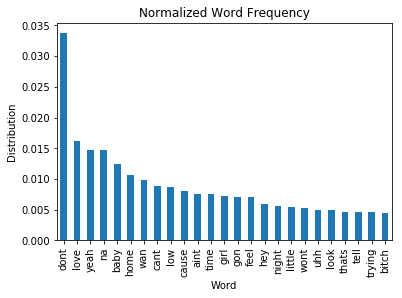

In [330]:
df = pd.DataFrame.from_dict(normalized_word_frequencies, orient='index')
word_freq = df.nlargest(25, 0).plot(kind='bar', title='Normalized Word Frequency', legend=False)
word_freq.set_xlabel("Word")
word_freq.set_ylabel("Distribution")

# Normalize and stem words

In [331]:
from nltk.stem import PorterStemmer

def stem_words(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in words]

normalized_word_frequencies = {}

for song in songs:
    song['word_lyrics'] = stem_words(remove_stop_words(word_tokenize(remove_punctuation(song['lyrics']))))
    dist = FreqDist(song['word_lyrics'])

    for w in dist:
        if not w in normalized_word_frequencies:
            normalized_word_frequencies[w] = 0

        normalized_word_frequencies[w] = normalized_word_frequencies[w] + dist.freq(w)
        
for w, v in normalized_word_frequencies.items():
    normalized_word_frequencies[w] = v / len(songs)

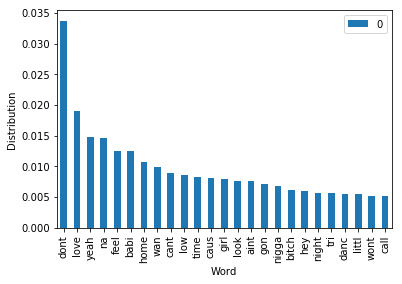

In [332]:
df = pd.DataFrame.from_dict(normalized_word_frequencies, orient='index')
word_freq = df.nlargest(25, 0).plot(kind='bar')
word_freq.set_xlabel("Word")
word_freq.set_ylabel("Distribution")

# Stemmed and normalized swear word frequency

In [333]:
swear_words = set(stem_words(corpus.swear_words()))

normalized_word_frequencies = {}

for song in songs:
    song['word_lyrics'] = stem_words(remove_stop_words(word_tokenize(remove_punctuation(song['lyrics']))))
    dist = FreqDist(song['word_lyrics'])

    for sw in swear_words:
        if not sw in normalized_word_frequencies:
            normalized_word_frequencies[sw] = 0

        normalized_word_frequencies[sw] = normalized_word_frequencies[sw] + dist.freq(sw)
        
for w, v in normalized_word_frequencies.items():
    normalized_word_frequencies[w] = v / len(songs)

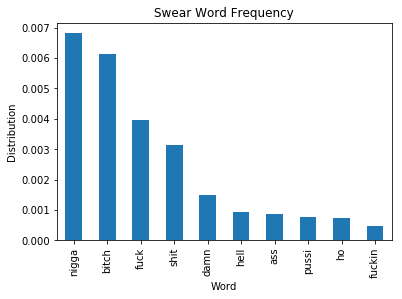

In [334]:
df = pd.DataFrame.from_dict(normalized_word_frequencies, orient='index')
word_freq = df.nlargest(10, 0).plot(kind='bar', title='Swear Word Frequency', legend=False)
word_freq.set_xlabel("Word")
word_freq.set_ylabel("Distribution")

# Sentiment analysis with Vader

In [335]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize


def split_sentences(text):
    sentences = []
    for sentence in text.split('\n'):
        sentence = sentence.strip()
        
        if sentence:
            sentences.append(sentence)

    return sentences


def sentiment_for_song(text):
    sid = SentimentIntensityAnalyzer()

    # can't use sent_tokenize with lyrics... just split on newline
    sentences = split_sentences(text)
    total_ss = {
        'negative': 0,
        'positive': 0,
        'neutral': 0,
        'compound': 0
    }

    for sentence in sentences:
        ss = sid.polarity_scores(sentence)
        total_ss['negative'] = total_ss['negative'] + ss['neg']
        total_ss['positive'] = total_ss['positive'] + ss['pos']
        total_ss['neutral'] = total_ss['neutral'] + ss['neu']
        total_ss['compound'] = total_ss['compound'] + ss['compound']
        
    for key in total_ss:
        total_ss[key] = total_ss[key] / len(sentences)
        
    return total_ss

all_sentiments = {}
for song in songs:
    sentiments = sentiment_for_song(song['lyrics'])

    # add sentiment to song data
    song['positive_sentiment'] = sentiments['positive']
    song['negative_sentiment'] = sentiments['negative']
    song['neutral_sentiment'] = sentiments['neutral']
    
    for key in sentiments:
        if key not in all_sentiments:
            all_sentiments[key] = 0
            
        all_sentiments[key] = all_sentiments[key] + sentiments[key]

# normalize for number of songs
for key in all_sentiments:
    all_sentiments[key] = all_sentiments[key] / len(songs)

print(all_sentiments)

{'negative': 0.08538988774533011, 'positive': 0.11905898567659678, 'neutral': 0.7955515403012989, 'compound': 0.03935044543716692}


# Plot sentiments

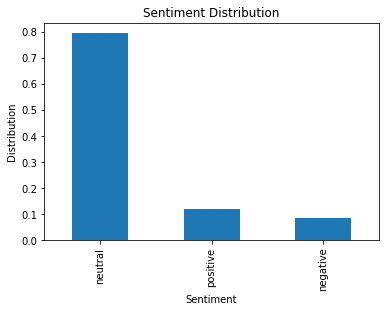

In [336]:
all_sentiments.pop('compound', 0)
df = pd.DataFrame.from_dict(all_sentiments, orient='index')
sent_plot = df.nlargest(10, 0).plot(kind='bar', title='Sentiment Distribution', legend=False)
sent_plot.set_xlabel("Sentiment")
sent_plot.set_ylabel("Distribution")

# 5 most negative songs

In [337]:
songs_df = pd.DataFrame.from_dict(songs)
songs_df.nlargest(5, 'negative_sentiment')

,artist,lyrics,lyrics_file,lyrics_file_path,lyrics_source,negative_sentiment,neutral_sentiment,positive_sentiment,rank_differential,rank_last_week,rank_this_week,title,word_lyrics
18,Jon Bellion,Low low low low low\nLow low low low low low l...,jon-bellion-all-time-low.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.648732,0.314293,0.036976,-0.03,22,19,All Time Low,"[low, low, low, low, low, low, low, low, low, ..."
64,Auli'i Cravalho,I got this feeling on the summer day when you ...,aulii-cravalho-how-far-ill-go.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.342167,0.566556,0.091278,-0.02,67,65,How Far I'll Go,"[feel, summer, day, gone, crash, car, bridg, w..."
88,Marshmello,I'm so alone\nNothing feels like home\nI'm so ...,marshmello-alone.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.267000,0.642000,0.091000,0.29,60,89,Alone,"[feel, home, tri, home, feel, home, tri, home,..."
98,Ugly God,I drip on your bitch like water\nI splash on y...,ugly-god-water.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.266914,0.551886,0.181229,0.19,80,99,Water,"[drip, bitch, water, splash, bitch, water, fee..."
60,21 Savage & Metro Boomin,"\nYoung Savage, why you trappin' so hard?\nWhy...",21-savage-metro-boomin-no-heart.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.219706,0.716279,0.064000,0.11,50,61,No Heart,"[savag, trappin, hard, nigga, cappin, hard, 12..."


# 5 most positive songs

In [338]:
songs_df.nlargest(5, 'positive_sentiment')

,artist,lyrics,lyrics_file,lyrics_file_path,lyrics_source,negative_sentiment,neutral_sentiment,positive_sentiment,rank_differential,rank_last_week,rank_this_week,title,word_lyrics
37,Sia Featuring Kendrick Lamar,"Uh-oh, running out of breath, but I\nOh, I, I ...",sia-featuring-kendrick-lamar-the-greatest.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.014704,0.579225,0.406085,-0.01,39,38,The Greatest,"[uhoh, run, breath, stamina, uhoh, run, close,..."
32,John Legend,"Pulling me further, further than I've been bef...",john-legend-love-me-now.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.059218,0.641345,0.299418,0.02,31,33,Love Me Now,"[pull, ive, stronger, shake, core, dont, what,..."
34,Little Big Town,I know I'm probably better off on my own\nThan...,little-big-town-better-man.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.044571,0.659024,0.296286,-0.06,41,35,Better Man,"[probabl, own, love, didnt, perman, damag, wis..."
90,John Mayer,"\nIt's a Friday, we finally made it\nI can't b...",john-mayer-love-on-the-weekend.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.028432,0.684568,0.287027,0.91,0,91,Love On The Weekend,"[friday, final, cant, believ, youv, ive, wait,..."
69,Andy Grammer,"I got these fresh eyes, never seen you before ...",andy-grammer-fresh-eyes.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.027200,0.727857,0.244943,0.02,68,70,Fresh Eyes,"[fresh, eye, seen, god, beauti, time, door, us..."


# 5 most neutral songs

In [339]:
songs_df.nlargest(5, 'neutral_sentiment')

,artist,lyrics,lyrics_file,lyrics_file_path,lyrics_source,negative_sentiment,neutral_sentiment,positive_sentiment,rank_differential,rank_last_week,rank_this_week,title,word_lyrics
51,Marian Hill,Didn't even really wanna go\nBut if you get me...,marian-hill-down.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.018386,0.955159,0.026455,-0.47,99,52,Down,"[didnt, wan, na, there, bodi, floor, babi, add..."
68,Brett Eldredge,The radio and a sundress\nMakin' my world all ...,brett-eldredge-wanna-be-that-song.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.038955,0.952212,0.008833,0.05,64,69,Wanna Be That Song,"[radio, sundress, makin, world, mess, corner, ..."
76,Luis Fonsi Featuring Daddy Yankee,"Ay \nFonsi \nDY \nOh oh… \nOh no, oh no… \nOh ...",luis-fonsi-featuring-daddy-yankee-despacito.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.016727,0.945045,0.038227,-0.11,88,77,Despacito,"[ay, fonsi, dy, yeah, dididiri, daddi, sí, sab..."
67,Alessia Cara,Wooohhhh\n\nYou sheltered me from harm\nKept m...,alessia-cara-how-far-ill-go.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.015731,0.929423,0.054846,0.12,56,68,How Far I'll Go,"[wooohhhh, shelter, harm, kept, warm, kept, wa..."
63,Khalid,\n\n\n\nSend me your location lets\nFocus on c...,khalid-location.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.016184,0.926105,0.057711,-0.06,70,64,Location,"[send, locat, focu, commun, cuz, time, chanc, ..."


# How repititive?

Check how repititive a song is by looking at the number of occurences each phrase or sentence has. A lot of songs are repititive due to the nature of a chorus etc.. however some might be super repititve.

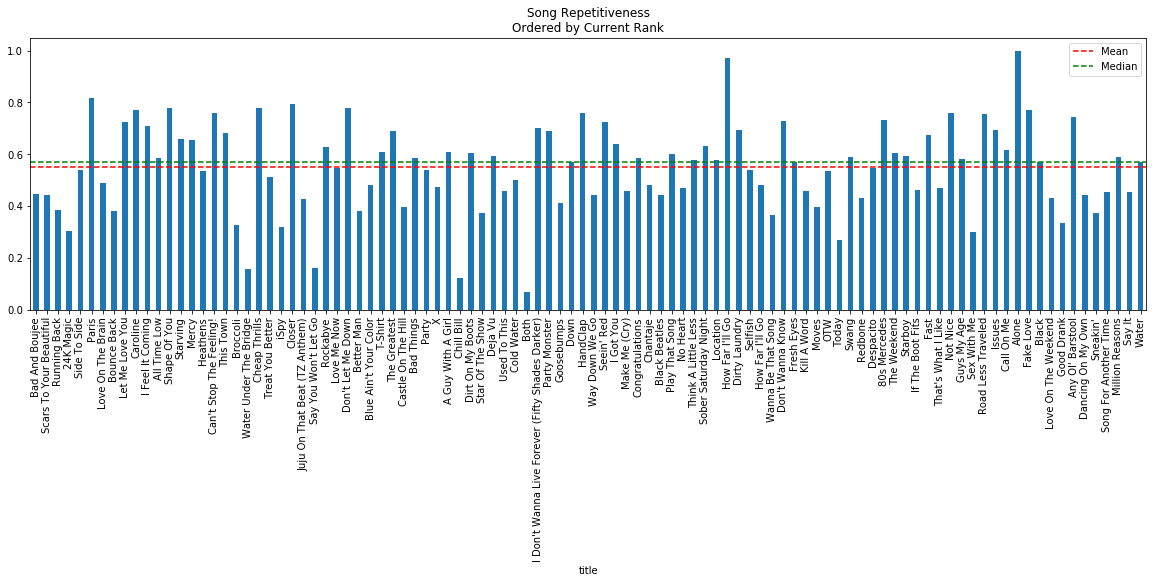

In [359]:
def song_repitiveness(lyrics, rate=2):
    # split song on sentence and find unique sentences
    sentences = split_sentences(lyrics)
    unique_sentences = set(sentences)
    
    total_sentences = len(sentences)
    total_unique_sentences = len(unique_sentences)
    
    # collect frequency of unique sentences and calculate reptitiveness
    repititive_rate = 0
    frequency = 0
    for usentence in unique_sentences:
        for sentence in sentences:
            if usentence == sentence:
                frequency = frequency + 1

        # only calc. reptitiveness rate if frequency rate cutoff is met
        if frequency >= rate:
            repititive_rate = repititive_rate + (frequency / total_sentences)
            
        frequency = 0
        
    return repititive_rate

for song in songs:
    song['repititiveness'] = song_repitiveness(song['lyrics'], rate=2)
    
songs_df = pd.DataFrame.from_dict(songs)
plot = songs_df.sort_values('rank_this_week').plot(x='title', y=('repititiveness'), kind='bar', title='Song Repetitiveness\nOrdered by Current Rank', stacked=True, figsize=(20,5))
mean = songs_df.mean()['repititiveness']
median = songs_df.median()['repititiveness']
mean_line = plot.axhline(mean, color='r', label='Mean', linestyle='--')
median_line = plot.axhline(median, color='g', label='Median', linestyle='--')
plot.legend(handles=[mean_line, median_line], loc=1)

In [341]:
songs_df.describe()

,negative_sentiment,neutral_sentiment,positive_sentiment,rank_differential,repititiveness
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.085390,0.795552,0.119059,0.098500,0.548873
std,0.085363,0.097600,0.071854,0.310241,0.169860
min,0.000000,0.314293,0.008833,-0.470000,0.066667
25%,0.035765,0.745895,0.066541,-0.040000,0.444444
50%,0.064605,0.806645,0.104816,0.000000,0.569805
75%,0.103589,0.859016,0.163132,0.080000,0.676705
max,0.648732,0.955159,0.406085,1.000000,1.000000


In [342]:
songs_df.sort_values('repititiveness').tail(10)

,artist,lyrics,lyrics_file,lyrics_file_path,lyrics_source,negative_sentiment,neutral_sentiment,positive_sentiment,rank_differential,rank_last_week,rank_this_week,repititiveness,title,word_lyrics
52,Fitz And The Tantrums,Somebody save your soul cause you've been sinn...,fitz-and-the-tantrums-handclap.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.036174,0.870674,0.093152,-0.01,54,53,0.760870,HandClap,"[save, soul, caus, youv, sin, citi, troubl, lo..."
16,Amine,Listen man\nWhat's up?\nI heard you done got y...,amine-caroline.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.145731,0.690564,0.163705,0.03,14,17,0.769231,Caroline,"[listen, what, heard, dime, piec, hell, naw, b..."
8,Drake,"Yeah, yeah\n\nI've been down so long it look l...",drake-fake-love.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.098404,0.717421,0.184281,-0.02,11,9,0.771930,Fake Love,"[yeah, yeah, ive, look, look, fake, peopl, sho..."
1,Ed Sheeran,\n\n\n\nThe club isn't the best place to find...,ed-sheeran-shape-of-you.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.021147,0.806789,0.172053,0.00,2,2,0.778947,Shape Of You,"[club, isnt, lover, bar, friend, tabl, do, sho..."
26,Sia Featuring Sean Paul,"Up with it, girl\nRock with it, girl (Sia)\nSh...",sia-featuring-sean-paul-cheap-thrills.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.018337,0.765930,0.215721,0.00,27,27,0.779070,Cheap Thrills,"[girl, rock, girl, sia, dem, girl, bada, bang,..."
33,The Chainsmokers Featuring Daya,"Crashing, hit a wall\nRight now I need a mirac...",the-chainsmokers-featuring-daya-dont-let-me-do...,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.035440,0.853620,0.110900,0.01,33,34,0.780000,Don't Let Me Down,"[crash, hit, wall, miracl, hurri, miracl, stra..."
2,The Chainsmokers Featuring Halsey,"Hey, I was doing just fine before I met you\nI...",the-chainsmokers-featuring-halsey-closer.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.074517,0.853517,0.071966,-0.01,4,3,0.793103,Closer,"[hey, do, fine, met, drink, that, issu, okay, ..."
12,The Chainsmokers,\n\n\n\nWe were staying in Paris\nTo get away...,the-chainsmokers-paris.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.009554,0.870892,0.119554,0.06,7,13,0.815385,Paris,"[stay, pari, parent, wow, shot, dont, terrac, ..."
64,Auli'i Cravalho,I got this feeling on the summer day when you ...,aulii-cravalho-how-far-ill-go.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.342167,0.566556,0.091278,-0.02,67,65,0.972222,How Far I'll Go,"[feel, summer, day, gone, crash, car, bridg, w..."
88,Marshmello,I'm so alone\nNothing feels like home\nI'm so ...,marshmello-alone.txt,/media/sf_D_DRIVE/jupyter/tyler/billboard_hot_...,songlyrics.com,0.267000,0.642000,0.091000,0.29,60,89,1.000000,Alone,"[feel, home, tri, home, feel, home, tri, home,..."


# Data correlations

In [357]:
songs_df.corr()

,negative_sentiment,neutral_sentiment,positive_sentiment,rank_differential,rank_last_week,rank_this_week,repititiveness
negative_sentiment,1.000000,-0.699131,-0.238394,0.000089,0.010942,0.011382,0.027998
neutral_sentiment,-0.699131,1.000000,-0.527711,-0.050100,0.081672,0.030672,-0.086096
positive_sentiment,-0.238394,-0.527711,1.000000,0.068032,-0.123997,-0.055156,0.083753
rank_differential,0.000089,-0.050100,0.068032,1.000000,-0.547377,0.504734,-0.003483
rank_last_week,0.010942,0.081672,-0.123997,-0.547377,1.000000,0.446183,-0.069328
rank_this_week,0.011382,0.030672,-0.055156,0.504734,0.446183,1.000000,-0.075239
repititiveness,0.027998,-0.086096,0.083753,-0.003483,-0.069328,-0.075239,1.000000


# Repititiveness and negative sentiment

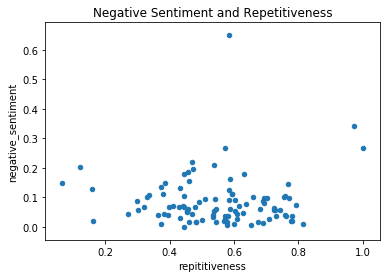

In [360]:
songs_df[['rank_this_week','rank_last_week']] = songs_df[['rank_this_week','rank_last_week']].apply(pd.to_numeric)
songs_df.plot('repititiveness', 'negative_sentiment', kind='scatter', title='Negative Sentiment and Repetitiveness')

# Repititiveness and positive sentiment

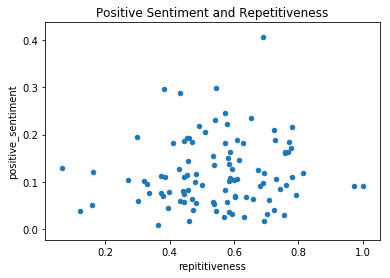

In [361]:
songs_df.plot('repititiveness', 'positive_sentiment', kind='scatter', title='Positive Sentiment and Repetitiveness')

# Rank and positive sentiment

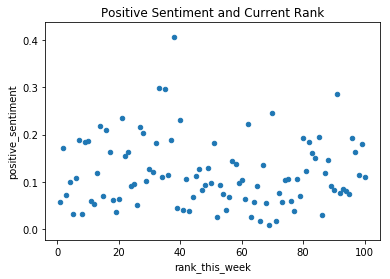

In [345]:
songs_df.plot('rank_this_week', 'positive_sentiment', kind='scatter', title='Positive Sentiment and Current Rank')

# Rank and negative sentiment

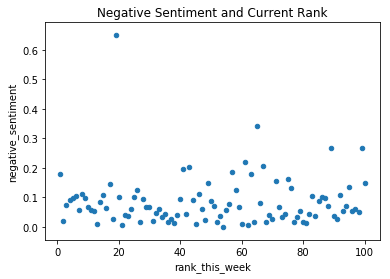

In [346]:
songs_df.plot('rank_this_week', 'negative_sentiment', kind='scatter', title='Negative Sentiment and Current Rank')

# Rank and repititiveness

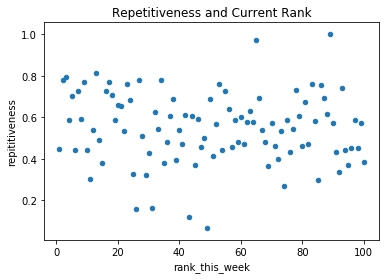

In [362]:
songs_df.plot('rank_this_week', 'repititiveness', kind='scatter', title='Repetitiveness and Current Rank')

# Common bigrams - bag of words - not normalized

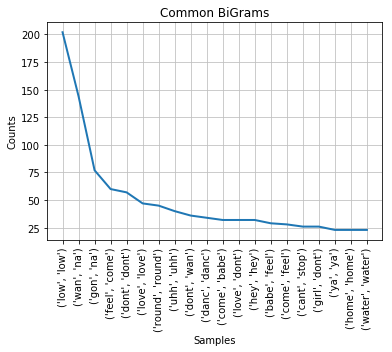

In [348]:
from nltk.util import ngrams

all_words = []
for song in songs:
    all_words = all_words + song['word_lyrics']

ngrams = ngrams(all_words, 2)
dist = FreqDist(ngrams)
dist.plot(20, title='Common BiGrams')

# Common trigrams - bag of words - not normalized

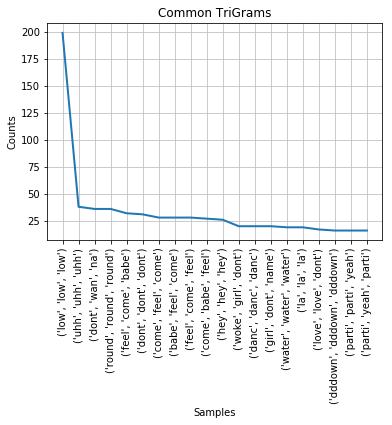

In [349]:
from nltk.util import ngrams

all_words = []
for song in songs:
    all_words = all_words + song['word_lyrics']

ngrams = ngrams(all_words, 3)
dist = FreqDist(ngrams)
dist.plot(20, title='Common TriGrams')

# Normalized trigrams

In [350]:
from nltk.util import ngrams

normalized_ngram_frequencies = {}

for song in songs:
    ngs = list(ngrams(song['word_lyrics'], 3))
    unique_ngs = set(ngs)
    dist = FreqDist(ngs)

    for ngram in unique_ngs:
        if not ngram in normalized_ngram_frequencies:
            normalized_ngram_frequencies[ngram] = 0
            
        normalized_ngram_frequencies[ngram] = normalized_ngram_frequencies[ngram] + dist.freq(ngram)
        
for ngram, v in normalized_ngram_frequencies.items():
    normalized_ngram_frequencies[ngram] = v / len(songs)

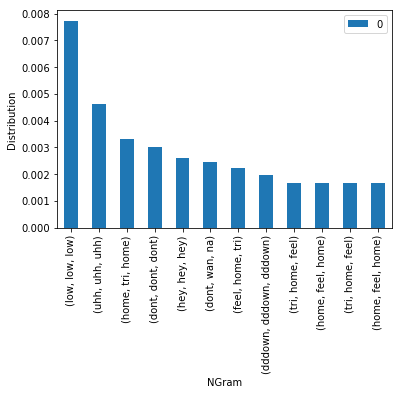

In [351]:
df = pd.DataFrame.from_dict(normalized_ngram_frequencies, orient='index')
word_freq = df.nlargest(10, 0).plot(kind='bar')
word_freq.set_xlabel("NGram")
word_freq.set_ylabel("Distribution")

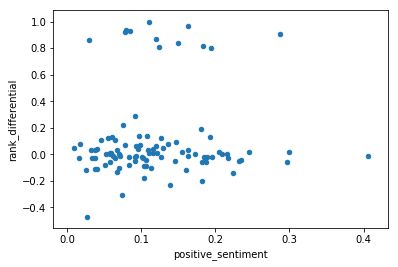

In [355]:
songs_df.plot(x='positive_sentiment', y='rank_differential', kind='scatter')